# Experiment 3.1.3: Faithfulness of Effects, continuous

In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torcheval.metrics.functional import r2_score

from captum.attr import IntegratedGradients, Saliency, NoiseTunnel, InputXGradient, LRP, DeepLift
from captum.attr._utils.lrp_rules import EpsilonRule

from scipy.interpolate import interp1d

#### Generate continuous data

In [2]:
def gen_data(num_features=12, num_samples=5000):

    mue = np.random.uniform(-2, 2, (num_features, 1))
    sigma = np.random.uniform(np.sqrt(0.9), np.sqrt(1.1), (num_features, 1))

    X = np.random.normal(mue, sigma, size=(num_features, num_samples)).T

    return X

#### Define the transformation functions

In [3]:
def g(X, func):
    if func == "Linear":
        return X
    
    elif func == "Piece-wise linear":
        pw_x = np.array([
            -6.25, -5.75, -5.25, -4.75, -4.25, -3.75, -3.25, -2.75, -2.25, -1.75,
            -1.25, -0.75, -0.25,  0.25,  0.75,  1.25,  1.75,  2.25,  2.75,  3.25,
            3.75,  4.25,  4.75,  5.25,  5.75,  6.25
        ])

        pw_y = np.array([
            -0.25, -0.15, -1.05, -1.15, -2.05, -2.25, -2.6, -2.6, -2.25, -2.15,
            -1.25, -1.15, -0.25, -0.25, -1.15, -1.25, -2.15, -2.25, -2.6, -2.6,
            -2.25, -2.05, -1.15, -1.05, -0.15, -0.25
        ]) + 1.5

        pw_linear = interp1d(pw_x, pw_y, kind='linear', fill_value="extrapolate", bounds_error=False)

        return(pw_linear(X))
    
    elif func == "Non-continuous":
        X_proc = X.copy()
        for i in range(len(X)):
            for j in range(len(X[0])):
                if np.abs(X[i,j]) <= 1.5:
                    X_proc[i,j] = np.where(np.abs(X[i,j]) < 0.4, 1, -1)
                else:
                    X_proc[i,j] = np.sign(X[i,j]) * 0.05 * (X[i,j]**2 - 1.5**2) - 1
        return X_proc
        
    elif func == "Exponential":
        return np.exp(X)
    
    else:
        return X

#### Calculate the Y with grouped beta

In [4]:
def calc_y(X, num_features, num_samples, func):

    epsilon = np.random.normal(0, 1, num_samples)

    beta = np.random.uniform(-1, 1, num_features + 1)
    beta[1:] = [0.1, 0.1, 0.1, 0.1, 0.4, 0.4, 0.4, 0.4, 1, 1, 1, 1]

    Y = beta[0] + np.sum(np.multiply(beta[1:], g(X, func)), axis=1) + epsilon

    return Y, beta

#### Define the neural network

In [5]:
class Net(nn.Module):

    def __init__(self, num_features):
        super(Net, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 1)
        )

    
    def forward(self, input):
        return self.net(input)

#### Split the data in train and test samples

In [6]:
def train_split(X, Y, num_samples, train_rate=0.8):
    index = int(num_samples * train_rate)

    X_train = X[:index]
    Y_train = Y[:index]

    X_test = X[index:]
    Y_test = Y[index:]

    return X_train, X_test, Y_train, Y_test

#### Define the z score preprocessing

In [7]:
def preprocess(X_train, X_test):
        
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)

    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std
    
    return X_train, X_test

#### Train the network

In [8]:
def train_model(net, X_train, X_test, Y_train, Y_test):
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train.reshape(-1, 1), dtype=torch.float32)

    highest_score = -10
    counter = 50
    PATH = "best_model_faith_con.pt"

    for epoch in range(300):
        net.train()
        optimizer.zero_grad()
        outputs = net(X_train_tensor)
        loss = loss_fn(outputs, Y_train_tensor)
        loss.backward()
        optimizer.step()

        r2 = r2_score(net.forward(torch.from_numpy(X_test).type(torch.FloatTensor)), torch.from_numpy(np.reshape(Y_test, (-1, 1))).type(torch.FloatTensor))

        if r2 > highest_score:
            highest_score = r2
            counter = 50
            torch.save(net.state_dict(), PATH)
        else:
            counter -= 1

        if counter == 0:
            break

    net.load_state_dict(torch.load(PATH, weights_only=True))
    net.eval()
        
    score = r2_score(net.forward(torch.from_numpy(X_test).type(torch.FloatTensor)), torch.from_numpy(np.reshape(Y_test, (-1, 1))).type(torch.FloatTensor))

    return net, score

#### Generate the attribution values

In [9]:
def calc_explanations(X_test, net):

    test_input_tensor = torch.from_numpy(X_test).type(torch.FloatTensor)

    test_input_tensor.requires_grad_()

    #Gradient

    sal = Saliency(net)

    attr_grad = sal.attribute(test_input_tensor, abs=False)
    attr_grad = attr_grad.detach().numpy()

    #Saliency

    attr_sal = np.square(attr_grad)

    #SmoothGrad

    sal = Saliency(net)
    nt = NoiseTunnel(sal)

    noise_level = 0.2
    stdev = (torch.max(test_input_tensor) - torch.min(test_input_tensor)).detach().item() * noise_level

    attr_sm_grad = nt.attribute(test_input_tensor, nt_samples=50, nt_type="smoothgrad", stdevs=stdev, abs=False)
    attr_sm_grad = attr_sm_grad.detach().numpy()

    #GradientxInput

    ixg = InputXGradient(net)

    attr_ixg = ixg.attribute(test_input_tensor)
    attr_ixg = attr_ixg.detach().numpy()

    #Lrp-epsilon

    net.net.rule = EpsilonRule(0.1)

    lrp = LRP(net)

    attr_lrp = lrp.attribute(test_input_tensor)
    attr_lrp = attr_lrp.detach().numpy()

    #SmoothGradXInput

    ixg = InputXGradient(net)
    nt_ixg = NoiseTunnel(ixg)

    attr_sm_ixg = nt_ixg.attribute(test_input_tensor, nt_samples=50, nt_type="smoothgrad", stdevs=stdev)
    attr_sm_ixg = attr_sm_ixg.detach().numpy()

    #Integrated Gradients

    ig = IntegratedGradients(net)

    attr_ig_zero = ig.attribute(test_input_tensor,baselines=0.0)
    attr_ig_zero = attr_ig_zero.detach().numpy()


    baseline_mean = torch.mean(torch.from_numpy(X_test), dim=0, keepdim=True).type(torch.FloatTensor)

    ig = IntegratedGradients(net)

    attr_ig_mean = ig.attribute(test_input_tensor,baselines=baseline_mean)
    attr_ig_mean = attr_ig_mean.detach().numpy()
    
    #DeepLIFT

    dl = DeepLift(net)

    attr_dl_zero = dl.attribute(test_input_tensor, baselines=0.0)
    attr_dl_zero = attr_dl_zero.detach().numpy()

    dl = DeepLift(net)

    attr_dl_mean = dl.attribute(test_input_tensor, baselines=baseline_mean)
    attr_dl_mean = attr_dl_mean.detach().numpy()

    return attr_grad, attr_sal, attr_sm_grad, attr_ixg, attr_lrp, attr_sm_ixg, attr_ig_zero, attr_ig_mean, attr_dl_zero, attr_dl_mean

#### Compute the correlation values

In [10]:
def correlations(attr, feature_importance, num_features):
    explainations = attr.T

    corr_matrix = np.corrcoef(feature_importance, explainations)

    corr = [corr_matrix[i, num_features + i] for i in range(num_features)]

    return corr

#### Calculate the true feature effects from the inputs

In [11]:
def calc_feature_importance(X_test, beta, func):
    feature_importance = np.multiply(beta[1:], g(X_test, func)).T

    return feature_importance

#### Main method to conduct the simulation

In [12]:
num_features=12
num_samples=5000

scores = []

data = []

for func in ["Linear", "Piece-wise linear", "Non-continuous"]:

    scores = []

    for i in range(200):

        X = gen_data()

        Y, beta = calc_y(X, num_features, num_samples, func)
    
        net = Net(num_features)

        X_train, X_test, Y_train, Y_test = train_split(X, Y, num_samples)

        feature_importance = calc_feature_importance(X_test, beta, func)

        X_train, X_test = preprocess(X_train, X_test)

        net, score = train_model(net, X_train, X_test, Y_train, Y_test)

        scores.append(score)

        #print(score)

        attr_grad, attr_sal, attr_sm_grad, attr_ixg, attr_lrp, attr_sm_ixg, attr_ig_zero, attr_ig_mean, attr_dl_zero, attr_dl_mean = calc_explanations(X_test, net)

        for (attr, corr_method) in zip((attr_grad, attr_sm_grad, attr_sal, attr_ixg, attr_lrp, attr_sm_ixg, attr_ig_zero, attr_ig_mean, attr_dl_zero, attr_dl_mean),
                                  ("Gradient", "SmoothGrad", "Saliency", "InputxGrad", "LRP-ℇ", "SmoothGradxInput", "Integrated Gradient(zero)", 
                                   "Integrated Gradient(mean)", "DeepLift(zero)", "DeepLift(mean)")):
    
            correlation = correlations(attr, feature_importance, num_features)

            for ind in range(len(correlation)):
                if ind < 4:
                    data.append({
                        'Method': corr_method,
                        'FunctionType': func,
                        'FeatureEffect': "Weak",
                        'Correlation': correlation[ind]
                    })
                elif ind < 8:
                    data.append({
                        'Method': corr_method,
                        'FunctionType': func,
                        'FeatureEffect': "Medium",
                        'Correlation': correlation[ind]
                    })
                else:
                    data.append({
                        'Method': corr_method,
                        'FunctionType': func,
                        'FeatureEffect': "Strong",
                        'Correlation': correlation[ind]
                    })
        
    print(f"{func}: {np.mean(scores)}")

/opt/anaconda3/lib/python3.11/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Linear: 0.8041427135467529
Piece-wise linear: 0.5921663045883179
Non-continuous: 0.3580896854400635


#### Plot the simulation results

               Method    FunctionType FeatureEffect  Correlation
0            Gradient          Linear          Weak     0.653017
1            Gradient          Linear          Weak     0.495426
2            Gradient          Linear          Weak     0.110816
3            Gradient          Linear          Weak     0.504193
4            Gradient          Linear        Medium     0.266542
...               ...             ...           ...          ...
71995  DeepLift(mean)  Non-continuous        Medium     0.394151
71996  DeepLift(mean)  Non-continuous        Strong     0.755004
71997  DeepLift(mean)  Non-continuous        Strong     0.852502
71998  DeepLift(mean)  Non-continuous        Strong     0.687940
71999  DeepLift(mean)  Non-continuous        Strong     0.722122

[72000 rows x 4 columns]


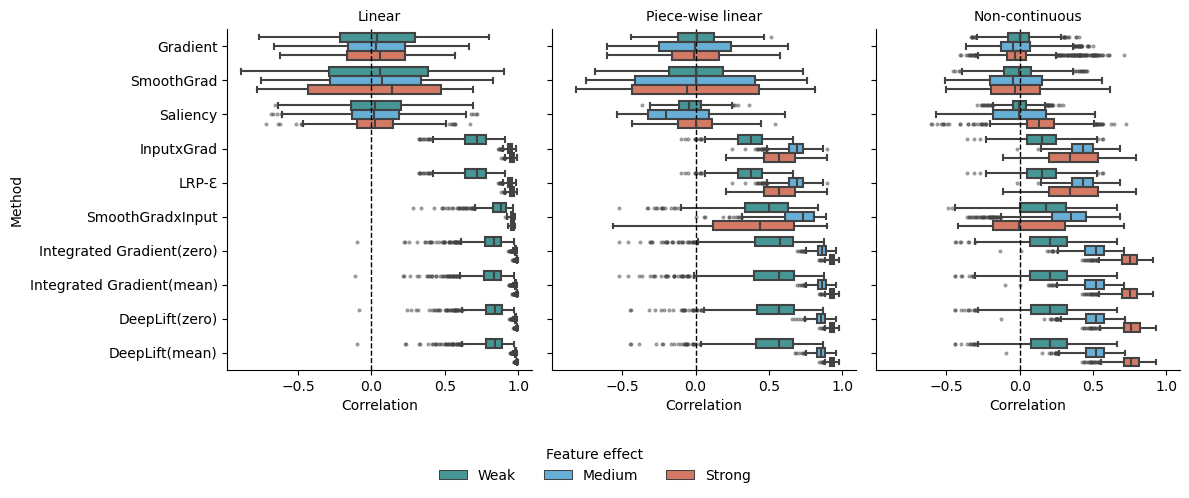

In [13]:

df = pd.DataFrame(data)
print(df)


flierprops = dict(marker='o', markersize=2, alpha=0.4)


g = sns.FacetGrid(
    df,
    col='FunctionType',
    sharex=True,
    height=5,
    aspect=0.8
)

g.map_dataframe(
    sns.boxplot,
    x='Correlation',
    y='Method',
    hue='FeatureEffect',
    palette={'Weak': '#39a3a3', 'Medium': '#56b4e9', 'Strong': '#e76f51'},
    flierprops=flierprops,
    dodge=True
)

for ax in g.axes.flatten():
    ax.axvline(0, color='black', linestyle='--', linewidth=1)

handles, labels = g.axes[0][0].get_legend_handles_labels()
g.figure.legend(handles, labels, title="Feature effect", loc='lower center', ncol=3, frameon=False, bbox_to_anchor=(0.5, 0))

g.set_titles("{col_name}")
plt.subplots_adjust(bottom=0.25)
plt.show()